# Days to Publication
In this example, we'll use webscraping techniques to collect data on the average number of days to publication (from manuscript reception to online publication) from scientific journals.  Once we have the data, we will use a simple linear regression model to try to predict the average number of days to publication from a few basic predictors.

### Import libraries

In [499]:
#For RSS feed parsing/webscraping
import feedparser
import urllib2
from bs4 import BeautifulSoup
import re
from selenium import webdriver #for website that require javascript, ie a web browser
from selenium.webdriver.remote.errorhandler import SessionNotCreatedException

#For data cleaning and visualization
import os
import dateutil.parser as dparser
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
pd.options.display.max_colwidth = 100

### Define filter_size
Define a helper function that will filter out longer text entries; when we are searching for "Published" and "Received" strings, we want to make sure we don't include any instances of these words in abstracts or other long bodies of text

In [3]:
def filter_size(l,size):
    return [item for item in l if len(item)<size]

### Define feed collectors
This is how we mass collect RSS feeds to search through.  Most publishers will have a home web page with links to the RSS feeds of all their journals. We will need to define a separate feed collector function for every publisher (in our case: ACS, RSC & APS) because the html structure differs for each publisher site. 
Alternatively, one could manually specify specific RSS feeds to check out by adding to the feeds dictionary by hand.
 
For each collector function, we pass in a dictionary whose keys are publishers. We create a new entry (a dictionary) for the present publisher. We then populate this dictionary with journal names as keys and links to the journal's RSS feed as values.

In [10]:
#Collect all RSS feeds from home web page of publisher: RSC
def rsc_collect(feeds):
    feeds['RSC']={}
    driver.get('http://pubs.rsc.org/en/ealerts/rssfeed') 
    html = driver.page_source
    soup = BeautifulSoup(html,'lxml')
    links = soup.find_all(attrs={"class": "rss_text"})
    for l in links:
        journal = l.a.string.replace(' ','')
        print journal, l.a['href']
        feeds['RSC'][journal]=feedparser.parse(l.a['href'])
    return

In [14]:
#Collect all RSS feeds from home web page of publisher: ACS
def acs_collect(feeds):
    feeds['ACS']={}
    driver.get('https://pubs.acs.org/page/follow.html#1c4fed33-6556-443d-ad77-2af8bd5227fb-b6de7b7c-de82-45a5-9538-313dd15c6659') #for website that require javascript/a web browser
    html = driver.page_source
    soup = BeautifulSoup(html,'lxml')
    feed_streams = soup.find_all(attrs={"class": "feeds"})
    for feed in feed_streams:
        for link in feed:
            #journals all start with '<'
            if str(link).startswith('<'):
                journal = link.a.string.replace(' ','')
                #remove cenNews & analyticalchemNews
                if 'News' in journal:
                    continue
                #Remove RSS feeds by topic; only include those by journal
                if link.a['href'].startswith('/topic'):
                    continue
                    
                print journal, link.a['href']
                feeds['ACS'][journal]=feedparser.parse(link.a['href'])
    return

In [7]:
#Collect all RSS feeds from home web page of publisher: APS
def aps_collect(feeds):
    feeds['APS']={}
    driver.get('https://journals.aps.org/feeds')
    html = driver.page_source
    soup = BeautifulSoup(html,'lxml')
    links = soup.find_all('h3')

    for l in links:
        if l.a and '/rss' in l.a['href']:
            if str(l).startswith('<h3>Physical') or str(l).startswith('<h3>Reviews'):
                journal =  l.text.strip()
                print journal
                print l.a['href']
                feeds['APS'][journal]=feedparser.parse(l.a['href'])
    return

### Collect RSS feeds
Now, we will run our RSS feed collector functions.
To access sites that require javascripts (which is most of those we're considering), we can't just read the raw source code of the websites.  Instead, we have to open a new session of an automated browser window to read the sites.  I am using Safari, but the below commands can be reconfigured for another browser.  If using Safari, ensure that you have checked the "Allow remote automation" option in the "Develop" click-down Safari menu. 
A finnicky aspect of this approach is that an error will be thrown if an automated session is already running.  To remedy this, we use a try/except block to catch the `SessionNotCreatedException`. 

In [ ]:
#Launch webdriver, may need to run twice to get rid of webdriver error
try:
    driver= webdriver.Safari()
except SessionNotCreatedException:
    pass

#Collect desired RSS feeds
feeds = {}
rsc_collect(feeds)
acs_collect(feeds)
#Unfortunately, APS flags automation and blocks IP address.  Won't include them for now.
#aps_collect(feeds)

In [ ]:
#Example output
#Analyst http://feeds.rsc.org/rss/an
#
#AnalyticalMethods http://feeds.rsc.org/rss/ay


### Prepare the dataframe
Now we need to get a dataframe ready to store all the data we will collect.  If you're starting from scratch, you can use the first command to create an empty dataframe with the necessary columns.  Or you can upload the pickle file provided.

In [203]:
#Create empty df template
#df = pd.DataFrame(columns=['Link','Title','Publisher','Journal','Authors','RDate','PDate'])

#Or import df from pkl file
df = pd.read_pickle('all-RSS.pkl')

### Collect article information
Ok! Now we are ready to collect article information and begin to populate our dataframe.  We will grab information like the title of the article, the authors, the received date and the date published online.

<font color=red>Warning! If you are on a network where you have read-access to the articles, your IP address will be flagged and you will lose access.</font>
Even though we are not mass downloading any article pdfs, the activity will resemble that, so the publishers will prevent you from accessing their website any more.  (APS does this even when you are not on a network that can access their articles).  For example, if you are a university student and you are on the university network, this may be the case.  To check whether you are on an accessible network, go to a couple of the article homepages manually and see if you can download the article pdf for free, or if you need to login/pay.  If you see you need to login/pay, then go ahead and continue!  Otherwise, wait until you are off of this network to proceed.

Another thing to note, is that this approach will only give us access to the articles still listed on a journal's RSS feed (ie they will be fairly recent articles).  Unfortunately, there is no easy way that I have found to automate the collection of this data from a longer timeframe.  

Final note: this will take some time! Good time to grab a coffee or take a lunch break.

In [ ]:
#Launch webdriver, may need to run twice to get rid of webdriver error
try:
    driver= webdriver.Safari()
except SessionNotCreatedException:
    pass

#Collect data!
for publisher in feeds:
    for feed in feeds[publisher]:
        for art in feeds[publisher][feed].entries:
            Title = art.title
            Link =  art.id
            print feed
            print Title, Link
            
            #check if article already in df
            if Link in df['Link'].values:
                print "Skipped: ",Link
                continue
            
            Authors = []
            try:
                for auth in art.authors:
                    Authors.append(auth['name'])
            except:
                Authors = None
            print Authors
            
            Publisher = publisher
            Journal=feed

            #urllib2.urlopen(art.link) #can be used only with non javascript sites
            driver.get(art.link) #for website that require javascript/a web browser
            html = driver.page_source
            soup = BeautifulSoup(html,'lxml')

            #find all instances mentioning published or received
            pub1 = soup.body.findAll(text=re.compile('[P,p]ublished \d{1,2}'),limit=3)
            pub2 = soup.body.findAll(text=re.compile('[P,p]ublished on'),limit=3)
            rec = soup.body.findAll(text=re.compile('[R,r]eceived '), limit=3)

            #remove longer instances, ie abstracts
            pub1 = filter_size(pub1,200)
            pub2 = filter_size(pub2,200)            
            rec = filter_size(rec,200)

            if len(pub1)>len(pub2):
                pub = pub1
            else:
                pub = pub2    
                
            #skip if more than one instance found of pub or rec
            if len(pub)!=1 or len(rec)!=1:
                print "Warning, missing or ambiguous rec/pub string instances; skipping"
                continue

            #Remove duplicate date entries (ie rec and pub mentioned in same string), may not matter
            if pub == rec:
                rec = [] 

            #For aps
            pub[0] = unicodedata.normalize('NFKD', pub[0]).encode('ascii','ignore')

            #Just skip entry if this step gives any problems
            try: 
                pubrec = str(' '.join(pub+rec).replace('\n',' '))
            except UnicodeEncodeError:
                print "Skipping: unable to parse unicode"
                continue
            
            print pubrec
            matches = re.findall(r'\d{1,2} [a-zA-Z]{3,8} \d{4}', pubrec)

            #Set so no duplicate dates added
            dates = set()
            RDate = None
            PDate = None
            for match in matches:
                date = dparser.parse(match,fuzzy=True)
                dates.add(date)

            #Assign published and received dates based on time sequence
            dates = list(dates)
            dates.sort()
            if len(dates)>=2:
                RDate =dates[0]
                PDate = dates[-1]

            #Append new data to df
            print "saving to DF:",Link
            df = df.append({'Authors':Authors,
                      'Journal':Journal,
                      'Link':Link,
                       'PDate':PDate,
                       'RDate':RDate,
                       'Publisher':Publisher,
                       'Title':Title,
                      },
                      ignore_index=True)
            print len(df)



In [ ]:
#Example output:
#ReactionChemistry&Engineering
#http://pubs.rsc.org/en/Content/ArticleLanding/2018/RE/C7RE00210F
#[u'Geun Ho Gu', u'Petr Plechac', u'Dionisios G. Vlachos']
#         The article was              received on 18 Dec 2017,              accepted on 13 Feb 2018  and            first published on 13 Feb 2018     
#saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/RE/C7RE00210F
#5882

### Analysis
Ok! Now that we've collected some article data, time to analyze it.  First, let's see how our dataframe looks.

In [424]:
df.head()

,Authors,Journal,Link,PDate,Publisher,RDate,Title,PubDays
0,"[Chen Zhao, Zongyue Zeng, Nader Taheri Qazvini, Xinyi Yu, Ruyi Zhang, Shujuan Yan, Yi Shu, Yunxi...",ACS Biomaterials Science & Engineering,http://dx.doi.org/10.1021/acsbiomaterials.8b00179,2018-06-07,ACS,2018-02-13,[ASAP] Thermoresponsive Citrate-Based Graphene Oxide Scaffold Enhances Bone Regeneration from BM...,114
1,"[Rosasilvia Raggio, Walter Bonani, Emanuela Callone, Sandra Dirè, Laura Gambari, Francesco Grass...",ACS Biomaterials Science & Engineering,http://dx.doi.org/10.1021/acsbiomaterials.8b00212,2018-07-06,ACS,2018-02-22,[ASAP] Silk Fibroin Porous Scaffolds Loaded with a Slow-Releasing Hydrogen Sulfide Agent (GYY413...,134
2,"[Paige J. LeValley, Ben Noren, Prathamesh M. Kharkar, April M. Kloxin, Jesse C. Gatlin, John S. ...",ACS Biomaterials Science & Engineering,http://dx.doi.org/10.1021/acsbiomaterials.8b00350,2018-07-05,ACS,2018-03-21,[ASAP] Fabrication of Functional Biomaterial Microstructures by in Situ Photopolymerization and ...,106
3,"[Jianming Chen, Jinlian Hu, Sono Sasaki, Kensuke Naka]",ACS Biomaterials Science & Engineering,http://dx.doi.org/10.1021/acsbiomaterials.8b00428,2018-07-06,ACS,2018-04-07,[ASAP] Modular Assembly of a Conserved Repetitive Sequence in the Spider Eggcase Silk: From Gene...,90
4,"[Wenyan Li, Guohui Zhang, Teng Guan, Xiaosha Zhang, Ali Khosrozadeh, Malcolm Xing, Jiming Kong]",ACS Biomaterials Science & Engineering,http://dx.doi.org/10.1021/acsbiomaterials.8b00654,2018-06-29,ACS,2018-06-07,[ASAP] Manipulable Permeability of Nanogel Encapsulation on Cells Exerts Protective Effect again...,22


In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5882 entries, 0 to 5881
Data columns (total 8 columns):
Authors      5882 non-null object
Journal      5882 non-null object
Link         5882 non-null object
PDate        5882 non-null datetime64[ns]
Publisher    5882 non-null object
RDate        5882 non-null datetime64[ns]
Title        5882 non-null object
PubDays      5882 non-null int64
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 573.6+ KB


### Cleaning Data
If you're using the provided dataframe, there will be a column called PubDays, the number of days from reception to online publication, and there should also be no null values.  The data is ready to analyze.

However, if you're collecting new or additional data, you'll need to do a little bit of cleaning: removing null values, removing all spaces from the journal titles, and calculating the PubDays column.

In [195]:
#Drop pubdays before removing na values
df.drop('PubDays',axis=1,inplace=True)

#ignore entries with na values
df.dropna(inplace=True)

#Re-create pubdays
df['PubDays'] = (df['PDate']-df['RDate']).dt.days

#Remove tabs and line breaks from journal names
df['Journal'] = df['Journal'].apply(lambda x: x.replace('\t','').replace('\n',''))

#Add proper spacing to journal names
def add_spaces(x):
    if 'ACS' in x:
        xs = re.sub(r"\B([A-Z])", r" \1", x.replace('ACS',''))
        xs = re.sub(r"(&)", r" \1 ", xs)
        xs='ACS '+xs
    else:
        xs = re.sub(r"\B([A-Z])", r" \1", x)
        xs = re.sub(r"(&)", r" \1 ", xs)
        xs = re.sub(r"(The Journalof)", r"Journal of", xs)
    return xs
df['Journal'] = df['Journal'].apply(add_spaces)

### Saving your data
Before we do anything else, it's a good idea to save this dataframe since the data collection is not trivial.

In [341]:
df.to_pickle('all-RSS.pkl')

### Visualization
Let's begin by simply visualizing the time to publication as a function of journal.  We'll start with a box plot.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 <a list of 80 Text xticklabel objects>)

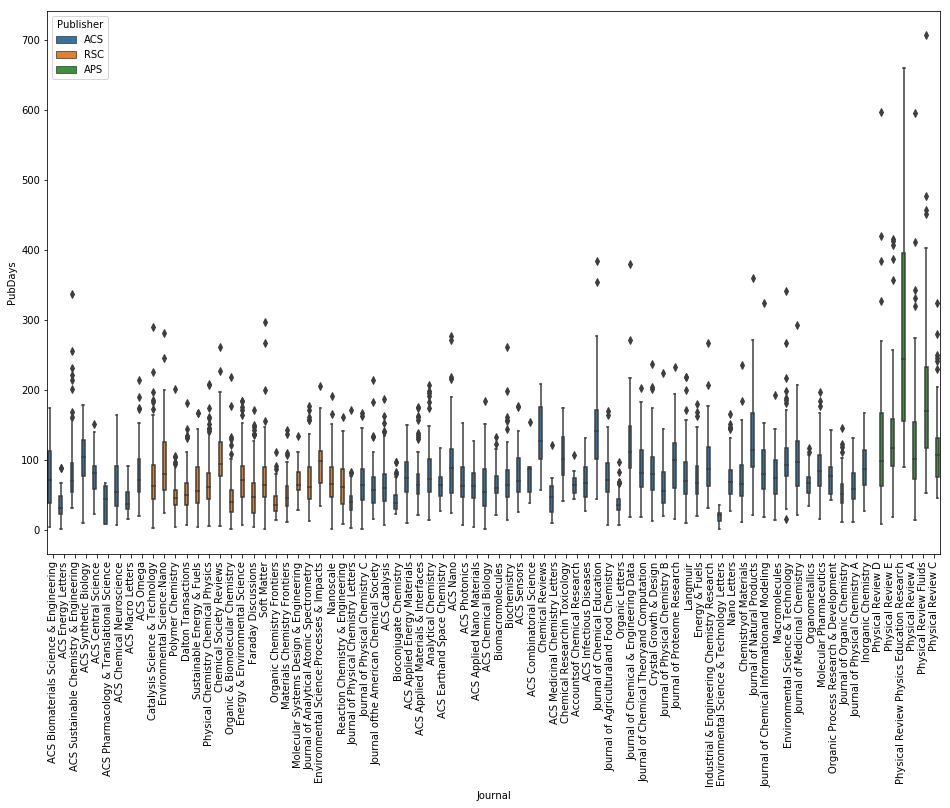

In [425]:
#Plotting
plt.figure(figsize=(16,10))
plt.clf()
#sns.swarmplot(x='Journal',y='PubDays',hue='Publisher',data=df,)
sns.boxplot(x='Journal',y='PubDays',hue='Publisher',data=df)
plt.xticks(rotation=90)

#### Wow!  
Looks like there are a <b>lot</b> of journals.  Let's get a closer look at journals that we have more than 50 data points for, so that the average date to publication we get is more statistical.

In [458]:
y = df.groupby('Journal')['Title'].count()
df_less = df[df['Journal'].apply(lambda x: y[x]>50)]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]), <a list of 55 Text xticklabel objects>)

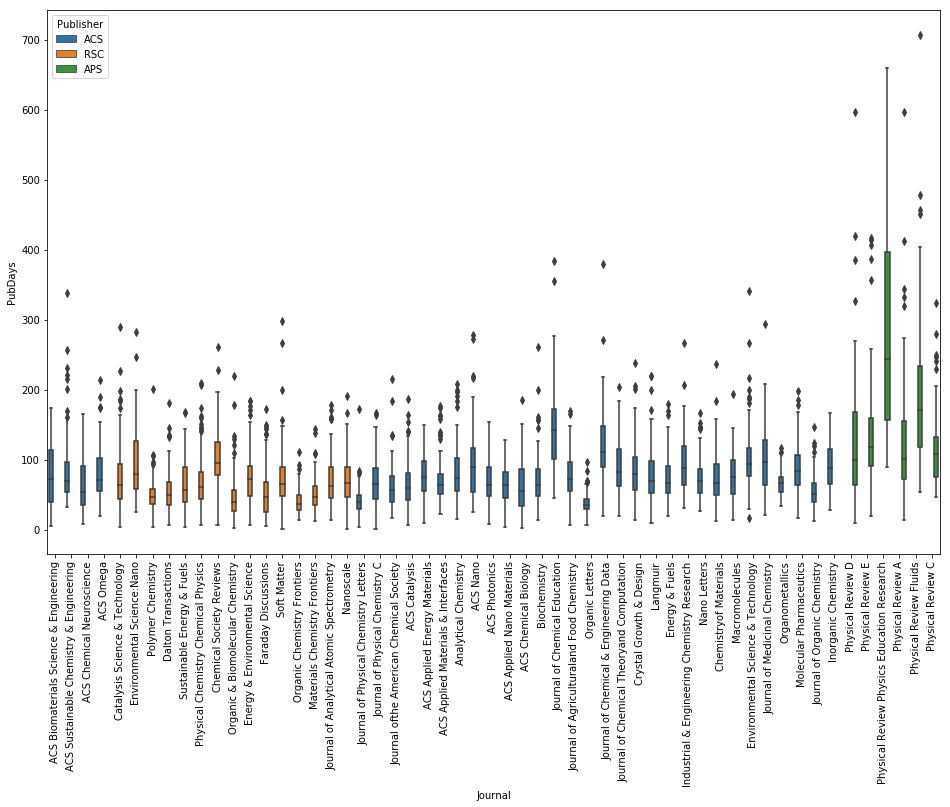

In [459]:
plt.figure(figsize=(16,10))
plt.clf()
#sns.swarmplot(x='Journal',y='PubDays',hue='Publisher',data=df_less,)
sns.boxplot(x='Journal',y='PubDays',hue='Publisher',data=df_less)
plt.xticks(rotation=90)

### Some observations...
It looks like the differences between time to publication among journals is not that significant; perhaps journals published by APS take slightly longer than those published by ACS and RSC.  Additionally, we see that ChemicalSocietyReviews has one of the higher averages out of the ASC and RSC journals, which makes sense since reviews tend to be more detailed than the average article.  The two journals that are Letters also seem to have shorter days to publication (as we would hope), but not by much.  


## Machine Learning
### Data cleaning
Now that we have a better feel for the data, let's see if we can predict the average days to publication of a journal based on some basic predictors.  Some obvious ones we just mentioned: it may be useful to know whether the journal is a letter or a review, and who the publisher was.  Another possibility that comes to my mind, is whether the journal's impact factor is at all correlated with publication time.  We might expect it to be a longer process to get an article accepted to a prestigious journal.  Given that idea, we'll join some impact factor data from Thomson Reuters with our dataframe

First, let's filter out journals with less than 15 articles to get a decent idea of the mean PubDays.  Then, let's boil down our dataframe to get rid of individual articles and include only average PubDays with the journals as keys.

In [471]:
y = df.groupby('Journal')['Title'].count()
df_s = df[df['Journal'].apply(lambda x: y[x]>15)]

#Get the average num pubdays per journal, retaining publisher
avg_pd = df_s.groupby('Journal').agg({'PubDays':'mean', 'Publisher':'first'})
avg_pd = avg_pd.reset_index()

#To avoid any case matching issues on the join we plan to do, let's make all journal titles lower case
avg_pd['Journal']=avg_pd['Journal'].str.lower()

Now let's go ahead and read in some journal impact data from Thomson Reuters, removing any "Not available" entries

In [472]:
ifs = pd.read_csv('journalimpactfactors2017.csv')
ifs['Journal'] = ifs['Journal'].str.lower()
ifs = ifs[ifs['Journal Impact Factor']!='Not Available']

Next we'll do an inner join on dataframes `avg_pd` and `ifs` using `Journal` as the key yielding a new dataframe, `jdf`.

In [473]:
jdf = avg_pd.join(ifs.set_index('Journal'),how='inner',on='Journal')
jdf.drop_duplicates(inplace=True)

### Extracting more predictors
As we noted before, it seemed like certain journal title key words might be useful in predicting the days to publication.  Here, we create additional machine-readable columns that denote whether a journal is educational, a letter, or a review.  We also separate the publisher column to be machine-readable, and remove thousand-separating commas from `Total Cites`.

In [474]:
jdf['Education']=jdf['Journal'].apply(lambda x: (int('educ' in x)))
jdf['Letter']=jdf['Journal'].apply(lambda x: (int('letter' in x)))
jdf['Review']=jdf['Journal'].apply(lambda x: (int('reviews' in x)))

publisher = pd.get_dummies(jdf['Publisher'],drop_first=True)
jdf = pd.concat([jdf,publisher],axis=1)
jdf.drop('Publisher',axis=1,inplace=True)
jdf['Total Cites']=jdf['Total Cites'].apply(lambda x: int(x.replace(',', '')))

### Training a model
Ok! Now we are ready to train a basic linear regression model.  We start by specifying a dataframe of predictors and a separate dataframe of the corresponding responses.

In [475]:
X = jdf.drop(['Journal','PubDays'],axis=1)
y = jdf['PubDays']

We import the linear regression model from sklearn, fit it to X and y, and make some predictions.  We plot the predicted PubDays versus the real values in a parity plot.

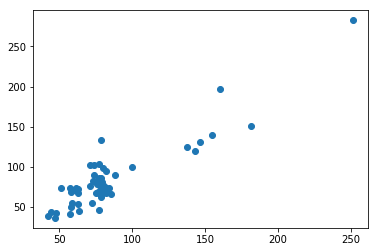

In [517]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,y)
predictions = lm.predict(X)
plt.scatter(predictions,y)

Not bad! Of course, this is an analysis of the training error, so we could be overfitting.  We are limited by only having ~60 data points to train on, but let's try to split our data into a training and testing set anyways to get a test error.

In [512]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

Refitting the model...

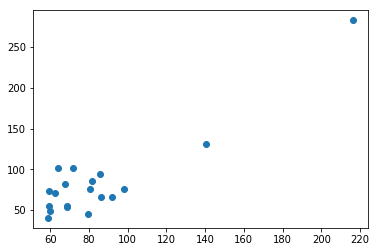

In [513]:
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
plt.scatter(predictions,y_test)

Still not too bad.  Of course, it would be helpful to have more data, and we can see that if the two high leverage points were not included in our test data our predictions might not look so great.  We can check out the mean absolute error, the root mean squared error, and the R^2 score to get a more quantitative feel for how well the model did.

In [514]:
from sklearn import metrics
print "MAE: ", metrics.mean_absolute_error(y_test,predictions)
print "RMSE: ", np.sqrt(metrics.mean_squared_error(y_test,predictions))
print "R2: ", metrics.r2_score(y_test,predictions)

MAE:  19.13299081866193
RMSE:  24.128228260425736
R2:  0.7817758298901024


The MAE and RMSE are good measures of what sort of prediction error we might expect if deploying this model in the real world.  They suggest we should be able to predict a journal's average days to publication with an average error of +/- 20-25 days, which is not bad considering the scale of our data is 250 days.  The R^2 also suggests that the model does well to account for the spread in the data, but if the two high leverage points at ~250 days and ~150 days were removed, we would have a much lower R^2 value.  Additionally, the shape of the data in the parity plots seems to suggest a linear model was a decent approximation.

Now let's see which descriptors the model found most useful in predicting the data.

In [518]:
pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])

,Coefficient
Rank,0.006472
Total Cites,-0.000098
Journal Impact Factor,1.027155
Eigenfactor Score,57.896743
Education,78.132410
Letter,-32.812382
Review,8.505212
APS,61.559091
RSC,-19.486617


`Rank` and `Total Cites` are ~0, which we might expect. `Rank` is a metric generated by Thomson Reuters, not an established metric of journal prestige, and total cites probably has more to do with how long the journal has been around for.  `Journal Impact Factor` and `Eigenfactor Score`, both well-known metrics indicating journal prestige, are positively correlated with the average number of days an article takes to get published.  Additionally, journals researching `Education` and `Reviews` are correlated with higher days to publication, whereas the classification of a journal as a `Letter` means it tends to have fewer days to publication.  Finally, `APS` journals tend to have slower turnaround times than `ACS`, and `RSC` is slightly faster than `ACS`.